# Variational Autoencoders for MNIST data augmentation

In [1]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F

from torchvision import datasets, transforms
import torchvision.datasets as dset
import torchvision.transforms as transforms

from torchvision.utils import save_image

from torch.autograd import Variable
from torch.autograd import Variable

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.model_selection import train_test_split

import os

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

root = './data'
if not os.path.exists(root):
    os.mkdir(root)

In [3]:
CUDA = use_cuda
SEED = 123
BATCH_SIZE = 128
LOG_INTERVAL = 25
EPOCHS_VAE = 20
EPOCHS_CNN = 25

ZDIMS = 128

## Load MNIST dataset

In [4]:
# DataLoader instances will load tensors directly into GPU memory
data_loader_args = {'num_workers': 1, 'pin_memory': True} if CUDA else {}
# data_loader_args = {}

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=BATCH_SIZE, shuffle=True, **data_loader_args)

# Same for test data
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../../data', train=False, transform=transforms.ToTensor()),
    batch_size=BATCH_SIZE, shuffle=True, **data_loader_args)

tensor([1, 4, 9, 3, 0, 0, 7, 9, 2, 5, 0, 0, 4, 1, 7, 5, 5, 8, 1, 3, 8, 8, 6, 1,
        7, 4, 7, 3, 2, 3, 1, 1, 1, 0, 5, 0, 3, 3, 9, 7, 1, 1, 9, 1, 3, 7, 5, 4,
        5, 5, 1, 5, 5, 7, 3, 8, 2, 3, 7, 7, 3, 6, 1, 8, 2, 6, 6, 0, 2, 0, 1, 0,
        5, 0, 8, 8, 0, 6, 3, 3, 9, 0, 4, 2, 8, 1, 1, 6, 4, 4, 0, 0, 2, 5, 0, 0,
        8, 6, 2, 8, 7, 3, 0, 6, 0, 3, 7, 2, 9, 7, 3, 8, 8, 9, 1, 9, 9, 7, 8, 8,
        8, 1, 1, 6, 2, 8, 3, 4])


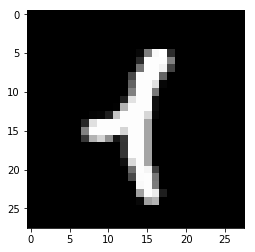

In [5]:
for img in train_loader:
    print(img[1])
    
    plt.imshow(img[0][0][0], cmap='gray')
    break

## Convolutional autoencoder

In [6]:
from cnn_vae import VAE, loss_function

In [7]:
def trainVAE(epoch):
    # toggle model to train mode
    model.train()
    train_loss = 0
    # in the case of MNIST, len(train_loader.dataset) is 60000
    # each `data` is of BATCH_SIZE samples and has shape [128, 1, 28, 28]
    for batch_idx, (data, _) in enumerate(train_loader):
        data = Variable(data)
        if CUDA:
            data = data.cuda()
        optimizer.zero_grad()

        # push whole batch of data through VAE.forward() to get recon_loss
        recon_batch, mu, logvar = model(data)
        # calculate scalar loss
        loss = loss_function(recon_batch, data, mu, logvar, BATCH_SIZE)
        # calculate the gradient of the loss w.r.t. the graph leaves
        # i.e. input variables -- by the power of pytorch!
        loss.backward()
        
        train_loss += loss.data.item()
        optimizer.step()
        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.data.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


In [8]:
def testVAE(epoch):
    # toggle model to test / inference mode
    model.eval()
    test_loss = 0

    # each data is of BATCH_SIZE (default 128) samples
    for i, (data, _) in enumerate(test_loader):
        if CUDA:
            # make sure this lives on the GPU
            data = data.cuda()

        # we're only going to infer, so no autograd at all required: volatile=True
        data = Variable(data, volatile=True)
        recon_batch, mu, logvar = model(data)
        test_loss += loss_function(recon_batch, data, mu, logvar, BATCH_SIZE).data.item()
        if i == 0:
          n = min(data.size(0), 8)
          # for the first 128 batch of the epoch, show the first 8 input digits
          # with right below them the reconstructed output digits
          comparison = torch.cat([data[:n],
                                  recon_batch.view(BATCH_SIZE, 1, 28, 28)[:n]])
          save_image(comparison.data.cpu(),
                     '../../results/DataAugMnist/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

## Train VAE model

In [9]:
model = VAE(ZDIMS)
if CUDA:
    model.cuda()

    
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [10]:
for epoch in range(1, EPOCHS_VAE + 1):
    trainVAE(epoch)
    testVAE(epoch)

    # 64 sets of random ZDIMS-float vectors, i.e. 64 locations / MNIST
    # digits in latent space
    sample = Variable(torch.randn(64, ZDIMS))
    if CUDA:
        sample = sample.cuda()
    sample = model.decode(sample).cpu()

    # save out as an 8x8 matrix EPOCHS_VAEof MNIST digits
    # this will give you a visual idea of how well latent space can generate things
    # that look like digits
    save_image(sample.data.view(64, 1, 28, 28),
               '../../results/DataAugMnist/sample_' + str(epoch) + '.png')

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.005472
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.002181
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.002121
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.002053
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.001935
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.001859
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.001707
Train Epoch: 1 [22400/60000 (37%)]	Loss: 0.001674
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.001661
Train Epoch: 1 [28800/60000 (48%)]	Loss: 0.001570
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.001562
Train Epoch: 1 [35200/60000 (59%)]	Loss: 0.001566
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.001552
Train Epoch: 1 [41600/60000 (69%)]	Loss: 0.001480
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.001497
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.001487
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.001505
Train Epoch: 1 [54400/60000 (91%)]	Loss: 0.001476
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.001426
====> Epoch: 1 Average loss: 0.0017


/home/andrew/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:13: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  del sys.path[0]


====> Test set loss: 0.0013
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.001362
Train Epoch: 2 [3200/60000 (5%)]	Loss: 0.001422
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.001432
Train Epoch: 2 [9600/60000 (16%)]	Loss: 0.001429
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.001406
Train Epoch: 2 [16000/60000 (27%)]	Loss: 0.001412
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.001382
Train Epoch: 2 [22400/60000 (37%)]	Loss: 0.001375
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.001322
Train Epoch: 2 [28800/60000 (48%)]	Loss: 0.001375
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.001348
Train Epoch: 2 [35200/60000 (59%)]	Loss: 0.001299
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.001292
Train Epoch: 2 [41600/60000 (69%)]	Loss: 0.001311
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.001319
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.001271
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.001249
Train Epoch: 2 [54400/60000 (91%)]	Loss: 0.001253
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.001226
====> Epoch: 2 Average loss: 0.

Train Epoch: 10 [9600/60000 (16%)]	Loss: 0.001062
Train Epoch: 10 [12800/60000 (21%)]	Loss: 0.001080
Train Epoch: 10 [16000/60000 (27%)]	Loss: 0.001063
Train Epoch: 10 [19200/60000 (32%)]	Loss: 0.001079
Train Epoch: 10 [22400/60000 (37%)]	Loss: 0.001095
Train Epoch: 10 [25600/60000 (43%)]	Loss: 0.001072
Train Epoch: 10 [28800/60000 (48%)]	Loss: 0.001052
Train Epoch: 10 [32000/60000 (53%)]	Loss: 0.001079
Train Epoch: 10 [35200/60000 (59%)]	Loss: 0.001050
Train Epoch: 10 [38400/60000 (64%)]	Loss: 0.001043
Train Epoch: 10 [41600/60000 (69%)]	Loss: 0.001085
Train Epoch: 10 [44800/60000 (75%)]	Loss: 0.001084
Train Epoch: 10 [48000/60000 (80%)]	Loss: 0.001047
Train Epoch: 10 [51200/60000 (85%)]	Loss: 0.001055
Train Epoch: 10 [54400/60000 (91%)]	Loss: 0.001048
Train Epoch: 10 [57600/60000 (96%)]	Loss: 0.001053
====> Epoch: 10 Average loss: 0.0011
====> Test set loss: 0.0010
Train Epoch: 11 [0/60000 (0%)]	Loss: 0.001082
Train Epoch: 11 [3200/60000 (5%)]	Loss: 0.001052
Train Epoch: 11 [6400/600

Train Epoch: 18 [9600/60000 (16%)]	Loss: 0.001031
Train Epoch: 18 [12800/60000 (21%)]	Loss: 0.001020
Train Epoch: 18 [16000/60000 (27%)]	Loss: 0.001027
Train Epoch: 18 [19200/60000 (32%)]	Loss: 0.001061
Train Epoch: 18 [22400/60000 (37%)]	Loss: 0.001033
Train Epoch: 18 [25600/60000 (43%)]	Loss: 0.001008
Train Epoch: 18 [28800/60000 (48%)]	Loss: 0.001010
Train Epoch: 18 [32000/60000 (53%)]	Loss: 0.001036
Train Epoch: 18 [35200/60000 (59%)]	Loss: 0.001077
Train Epoch: 18 [38400/60000 (64%)]	Loss: 0.001045
Train Epoch: 18 [41600/60000 (69%)]	Loss: 0.001047
Train Epoch: 18 [44800/60000 (75%)]	Loss: 0.001069
Train Epoch: 18 [48000/60000 (80%)]	Loss: 0.001092
Train Epoch: 18 [51200/60000 (85%)]	Loss: 0.001039
Train Epoch: 18 [54400/60000 (91%)]	Loss: 0.001061
Train Epoch: 18 [57600/60000 (96%)]	Loss: 0.001022
====> Epoch: 18 Average loss: 0.0010
====> Test set loss: 0.0010
Train Epoch: 19 [0/60000 (0%)]	Loss: 0.001039
Train Epoch: 19 [3200/60000 (5%)]	Loss: 0.001121
Train Epoch: 19 [6400/600

## Test VAE

tensor([ 1.7416, -0.4494, -1.5393,  1.7641, -0.7864, -0.3248,  0.7466, -1.2312,
         0.7799, -0.1441, -0.3679, -1.9061, -0.3663,  0.1879, -0.0119, -1.4089,
         0.4244, -0.1888, -0.0661,  0.0924,  0.0476, -0.6001,  0.7195, -0.4352,
         0.2438, -1.0774, -0.0711,  1.0658, -0.4765,  0.0412,  2.2564,  0.1813,
        -0.5998, -0.5044,  0.5572, -2.4805, -0.9488, -0.8033, -0.0782, -1.8207,
         0.4887, -1.4174,  0.8059,  1.0362,  1.0752,  0.3599, -0.8230, -0.5894,
         0.1953, -1.4199, -0.9571, -0.9667,  2.2781,  0.3292,  0.9407, -0.4168,
        -0.0285, -1.1563, -0.8244, -0.1053,  2.8702, -1.2540, -0.3503,  0.3558,
        -0.7666, -1.1887, -0.9050, -1.5172,  0.2614,  1.3053,  0.5407, -0.6132,
        -0.2109,  0.3712,  0.3177, -2.6164, -0.3256, -0.3775,  2.1733, -1.4884,
         0.6414,  0.2405,  0.1131,  2.7316, -1.5930, -0.3832,  0.0455,  0.3078,
         0.1134,  0.2823, -0.3758, -0.0336,  0.4241,  0.1043, -1.0183,  2.2212,
         0.1233,  0.0891,  0.3227,  0.35

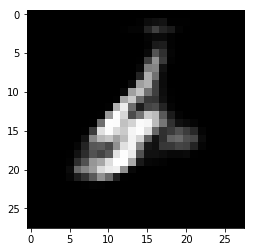

In [11]:
sample = Variable(torch.randn(1, ZDIMS))

if CUDA:
    sample = sample.cuda()

print(sample[0], sample[0].shape)

sample = model.decode(sample).cpu()

print(sample[0].shape)


img_data = sample.data.view(1, 28, 28).numpy()
plt.imshow(img_data[0], cmap='gray')

## Generate additional dataset based on the current MNIST

In [12]:
generated_dataset = []

for batch_idx, (data, labels) in enumerate(train_loader):
    data = Variable(data)
    if CUDA:
        data = data.cuda()
        
    x = data.view(-1, 784)

    out = model.transform(x)
    out = out.view(-1, 1, 28, 28)

    for index, el in enumerate(x):
        generated_dataset.append([out[index], labels[index]])
    
    if (batch_idx != 0) and (batch_idx % LOG_INTERVAL == 0):
        print("=== {} batches has been finished".format(batch_idx))

=== 25 batches has been finished
=== 50 batches has been finished
=== 75 batches has been finished
=== 100 batches has been finished
=== 125 batches has been finished
=== 150 batches has been finished
=== 175 batches has been finished
=== 200 batches has been finished
=== 225 batches has been finished
=== 250 batches has been finished
=== 275 batches has been finished
=== 300 batches has been finished
=== 325 batches has been finished
=== 350 batches has been finished
=== 375 batches has been finished
=== 400 batches has been finished
=== 425 batches has been finished
=== 450 batches has been finished


### Convert to dataset loader

In [15]:
import torch.utils.data as utils

generated_dataset_loader = utils.DataLoader(
    generated_dataset, 
    batch_size=BATCH_SIZE, 
#     **data_loader_args
)

# Comparison between CNNs trained on original, generated and both datasets

In [16]:
from cnn_mnist import CnnMNIST, trainCnn, testCnn

lr = 0.01
momentum = 0.5
do_save_model = True

### Only original dataset

In [15]:
cnn_orig = CnnMNIST().to(device)

optimizer = optim.SGD(cnn_orig.parameters(), lr=lr, momentum=momentum)

In [16]:
for epoch in range(1, EPOCHS_CNN + 1):
    trainCnn(cnn_orig, device, train_loader, optimizer, epoch)
    testCnn(cnn_orig, device, test_loader)

if (do_save_model):
    torch.save(cnn_orig.state_dict(), "./models/mnist_cnn_original_dataset.pt")

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.302496
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.267480
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.222275
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.112601
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.875953
Train Epoch: 1 [16000/60000 (27%)]	Loss: 1.444340
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.807467
Train Epoch: 1 [22400/60000 (37%)]	Loss: 0.669568
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.587505
Train Epoch: 1 [28800/60000 (48%)]	Loss: 0.488726
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.460813
Train Epoch: 1 [35200/60000 (59%)]	Loss: 0.381072
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.344590
Train Epoch: 1 [41600/60000 (69%)]	Loss: 0.364818
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.504403
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.258726
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.378197
Train Epoch: 1 [54400/60000 (91%)]	Loss: 0.344591
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.255430

Test set: Average loss: 0.3004, Accuracy: 9086/10000 (91%)

Train Epoch: 9 [12800/60000 (21%)]	Loss: 0.036297
Train Epoch: 9 [16000/60000 (27%)]	Loss: 0.044804
Train Epoch: 9 [19200/60000 (32%)]	Loss: 0.074958
Train Epoch: 9 [22400/60000 (37%)]	Loss: 0.015314
Train Epoch: 9 [25600/60000 (43%)]	Loss: 0.158304
Train Epoch: 9 [28800/60000 (48%)]	Loss: 0.118385
Train Epoch: 9 [32000/60000 (53%)]	Loss: 0.045000
Train Epoch: 9 [35200/60000 (59%)]	Loss: 0.061493
Train Epoch: 9 [38400/60000 (64%)]	Loss: 0.083825
Train Epoch: 9 [41600/60000 (69%)]	Loss: 0.095099
Train Epoch: 9 [44800/60000 (75%)]	Loss: 0.096041
Train Epoch: 9 [48000/60000 (80%)]	Loss: 0.035787
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.024807
Train Epoch: 9 [54400/60000 (91%)]	Loss: 0.040611
Train Epoch: 9 [57600/60000 (96%)]	Loss: 0.026484

Test set: Average loss: 0.0524, Accuracy: 9834/10000 (98%)

Train Epoch: 10 [0/60000 (0%)]	Loss: 0.035931
Train Epoch: 10 [3200/60000 (5%)]	Loss: 0.084687
Train Epoch: 10 [6400/60000 (11%)]	Loss: 0.049559
Train Epoch: 10 [9600/60000 (16%)]	Loss: 0.0

Train Epoch: 17 [16000/60000 (27%)]	Loss: 0.029237
Train Epoch: 17 [19200/60000 (32%)]	Loss: 0.051875
Train Epoch: 17 [22400/60000 (37%)]	Loss: 0.067540
Train Epoch: 17 [25600/60000 (43%)]	Loss: 0.012122
Train Epoch: 17 [28800/60000 (48%)]	Loss: 0.022072
Train Epoch: 17 [32000/60000 (53%)]	Loss: 0.030295
Train Epoch: 17 [35200/60000 (59%)]	Loss: 0.034527
Train Epoch: 17 [38400/60000 (64%)]	Loss: 0.047198
Train Epoch: 17 [41600/60000 (69%)]	Loss: 0.026711
Train Epoch: 17 [44800/60000 (75%)]	Loss: 0.073980
Train Epoch: 17 [48000/60000 (80%)]	Loss: 0.015250
Train Epoch: 17 [51200/60000 (85%)]	Loss: 0.002979
Train Epoch: 17 [54400/60000 (91%)]	Loss: 0.020874
Train Epoch: 17 [57600/60000 (96%)]	Loss: 0.024735

Test set: Average loss: 0.0404, Accuracy: 9869/10000 (99%)

Train Epoch: 18 [0/60000 (0%)]	Loss: 0.044950
Train Epoch: 18 [3200/60000 (5%)]	Loss: 0.038908
Train Epoch: 18 [6400/60000 (11%)]	Loss: 0.023457
Train Epoch: 18 [9600/60000 (16%)]	Loss: 0.057221
Train Epoch: 18 [12800/60000 (

Train Epoch: 25 [19200/60000 (32%)]	Loss: 0.011295
Train Epoch: 25 [22400/60000 (37%)]	Loss: 0.017763
Train Epoch: 25 [25600/60000 (43%)]	Loss: 0.034595
Train Epoch: 25 [28800/60000 (48%)]	Loss: 0.007433
Train Epoch: 25 [32000/60000 (53%)]	Loss: 0.011291
Train Epoch: 25 [35200/60000 (59%)]	Loss: 0.014278
Train Epoch: 25 [38400/60000 (64%)]	Loss: 0.010595
Train Epoch: 25 [41600/60000 (69%)]	Loss: 0.018615
Train Epoch: 25 [44800/60000 (75%)]	Loss: 0.044806
Train Epoch: 25 [48000/60000 (80%)]	Loss: 0.006383
Train Epoch: 25 [51200/60000 (85%)]	Loss: 0.049688
Train Epoch: 25 [54400/60000 (91%)]	Loss: 0.015845
Train Epoch: 25 [57600/60000 (96%)]	Loss: 0.008334

Test set: Average loss: 0.0313, Accuracy: 9899/10000 (99%)



### Only generated with VAE dataset

In [17]:
cnn_gener = CnnMNIST().to(device)

optimizer_gener = optim.SGD(cnn_gener.parameters(), lr=lr, momentum=momentum)

In [21]:
for epoch in range(1, EPOCHS_CNN + 1):
    trainCnn(cnn_gener, device, generated_dataset_loader, optimizer_gener, epoch)
    testCnn(cnn_gener, device, test_loader)

if (do_save_model):
    torch.save(cnn_gener.state_dict(), "./models/mnist_cnn_generated_dataset.pt")

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.184269
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.139451
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.188001
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.195631
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.200651
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.198346
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.168618
Train Epoch: 1 [22400/60000 (37%)]	Loss: 0.260448
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.170182
Train Epoch: 1 [28800/60000 (48%)]	Loss: 0.150557
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.249887
Train Epoch: 1 [35200/60000 (59%)]	Loss: 0.132149
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.122369
Train Epoch: 1 [41600/60000 (69%)]	Loss: 0.190676
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.210463
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.197649
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.138534
Train Epoch: 1 [54400/60000 (91%)]	Loss: 0.262526
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.165070


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f91099abac8>>
Traceback (most recent call last):
  File "/home/andrew/anaconda3/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 717, in __del__
    self._shutdown_workers()
  File "/home/andrew/anaconda3/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 704, in _shutdown_workers
    self.worker_result_queue.close()
  File "/home/andrew/anaconda3/lib/python3.5/multiprocessing/queues.py", line 134, in close
    self._reader.close()
  File "/home/andrew/anaconda3/lib/python3.5/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/home/andrew/anaconda3/lib/python3.5/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor



Test set: Average loss: 0.1575, Accuracy: 9522/10000 (95%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.131870
Train Epoch: 2 [3200/60000 (5%)]	Loss: 0.108815
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.145140
Train Epoch: 2 [9600/60000 (16%)]	Loss: 0.139340
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.134125
Train Epoch: 2 [16000/60000 (27%)]	Loss: 0.171922
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.123739
Train Epoch: 2 [22400/60000 (37%)]	Loss: 0.207163
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.124980
Train Epoch: 2 [28800/60000 (48%)]	Loss: 0.094306
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.211618
Train Epoch: 2 [35200/60000 (59%)]	Loss: 0.096938
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.095349
Train Epoch: 2 [41600/60000 (69%)]	Loss: 0.148907
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.161577
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.151843
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.112619
Train Epoch: 2 [54400/60000 (91%)]	Loss: 0.234502
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.14310

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f91099abac8>>
Traceback (most recent call last):
  File "/home/andrew/anaconda3/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 717, in __del__
    self._shutdown_workers()
  File "/home/andrew/anaconda3/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 704, in _shutdown_workers
    self.worker_result_queue.close()
  File "/home/andrew/anaconda3/lib/python3.5/multiprocessing/queues.py", line 134, in close
    self._reader.close()
  File "/home/andrew/anaconda3/lib/python3.5/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/home/andrew/anaconda3/lib/python3.5/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor



Test set: Average loss: 0.1241, Accuracy: 9623/10000 (96%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.098540
Train Epoch: 3 [3200/60000 (5%)]	Loss: 0.090912
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.113659
Train Epoch: 3 [9600/60000 (16%)]	Loss: 0.105934
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.100989
Train Epoch: 3 [16000/60000 (27%)]	Loss: 0.157943
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.102674
Train Epoch: 3 [22400/60000 (37%)]	Loss: 0.174911
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.104828
Train Epoch: 3 [28800/60000 (48%)]	Loss: 0.062262
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.189642
Train Epoch: 3 [35200/60000 (59%)]	Loss: 0.075670
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.081181
Train Epoch: 3 [41600/60000 (69%)]	Loss: 0.117782
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.138599
Train Epoch: 3 [48000/60000 (80%)]	Loss: 0.127681
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.093977
Train Epoch: 3 [54400/60000 (91%)]	Loss: 0.217397
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.12773

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f91099abac8>>
Traceback (most recent call last):
  File "/home/andrew/anaconda3/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 717, in __del__
    self._shutdown_workers()
  File "/home/andrew/anaconda3/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 704, in _shutdown_workers
    self.worker_result_queue.close()
  File "/home/andrew/anaconda3/lib/python3.5/multiprocessing/queues.py", line 134, in close
    self._reader.close()
  File "/home/andrew/anaconda3/lib/python3.5/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/home/andrew/anaconda3/lib/python3.5/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor



Test set: Average loss: 0.1036, Accuracy: 9693/10000 (97%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.076048
Train Epoch: 4 [3200/60000 (5%)]	Loss: 0.077536
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.090363
Train Epoch: 4 [9600/60000 (16%)]	Loss: 0.084961
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.084037
Train Epoch: 4 [16000/60000 (27%)]	Loss: 0.148270
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.094624
Train Epoch: 4 [22400/60000 (37%)]	Loss: 0.152667
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.095998
Train Epoch: 4 [28800/60000 (48%)]	Loss: 0.045998
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.174561
Train Epoch: 4 [35200/60000 (59%)]	Loss: 0.063509
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.071044
Train Epoch: 4 [41600/60000 (69%)]	Loss: 0.095605
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.122159
Train Epoch: 4 [48000/60000 (80%)]	Loss: 0.110774
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.082293
Train Epoch: 4 [54400/60000 (91%)]	Loss: 0.201404
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.11823

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f91099abac8>>
Traceback (most recent call last):
  File "/home/andrew/anaconda3/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 717, in __del__
    self._shutdown_workers()
  File "/home/andrew/anaconda3/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 704, in _shutdown_workers
    self.worker_result_queue.close()
  File "/home/andrew/anaconda3/lib/python3.5/multiprocessing/queues.py", line 134, in close
    self._reader.close()
  File "/home/andrew/anaconda3/lib/python3.5/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/home/andrew/anaconda3/lib/python3.5/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor



Test set: Average loss: 0.0904, Accuracy: 9735/10000 (97%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.062093
Train Epoch: 5 [3200/60000 (5%)]	Loss: 0.066386
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.074438
Train Epoch: 5 [9600/60000 (16%)]	Loss: 0.070285
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.073621
Train Epoch: 5 [16000/60000 (27%)]	Loss: 0.140569
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.092295
Train Epoch: 5 [22400/60000 (37%)]	Loss: 0.135891
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.090865
Train Epoch: 5 [28800/60000 (48%)]	Loss: 0.036758
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.163449
Train Epoch: 5 [35200/60000 (59%)]	Loss: 0.055897
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.062739
Train Epoch: 5 [41600/60000 (69%)]	Loss: 0.082442
Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.111616
Train Epoch: 5 [48000/60000 (80%)]	Loss: 0.099584
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.074015
Train Epoch: 5 [54400/60000 (91%)]	Loss: 0.190456
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.11328

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f91099abac8>>
Traceback (most recent call last):
  File "/home/andrew/anaconda3/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 717, in __del__
    self._shutdown_workers()
  File "/home/andrew/anaconda3/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 704, in _shutdown_workers
    self.worker_result_queue.close()
  File "/home/andrew/anaconda3/lib/python3.5/multiprocessing/queues.py", line 134, in close
    self._reader.close()
  File "/home/andrew/anaconda3/lib/python3.5/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/home/andrew/anaconda3/lib/python3.5/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor



Test set: Average loss: 0.0819, Accuracy: 9757/10000 (98%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.054007
Train Epoch: 6 [3200/60000 (5%)]	Loss: 0.057162
Train Epoch: 6 [6400/60000 (11%)]	Loss: 0.062405
Train Epoch: 6 [9600/60000 (16%)]	Loss: 0.060427
Train Epoch: 6 [12800/60000 (21%)]	Loss: 0.068653
Train Epoch: 6 [16000/60000 (27%)]	Loss: 0.133401
Train Epoch: 6 [19200/60000 (32%)]	Loss: 0.091637
Train Epoch: 6 [22400/60000 (37%)]	Loss: 0.121764
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.088154
Train Epoch: 6 [28800/60000 (48%)]	Loss: 0.031150
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.154451
Train Epoch: 6 [35200/60000 (59%)]	Loss: 0.049837
Train Epoch: 6 [38400/60000 (64%)]	Loss: 0.056397
Train Epoch: 6 [41600/60000 (69%)]	Loss: 0.072556
Train Epoch: 6 [44800/60000 (75%)]	Loss: 0.102844
Train Epoch: 6 [48000/60000 (80%)]	Loss: 0.091068
Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.070195
Train Epoch: 6 [54400/60000 (91%)]	Loss: 0.183267
Train Epoch: 6 [57600/60000 (96%)]	Loss: 0.10815

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f91099abac8>>
Traceback (most recent call last):
  File "/home/andrew/anaconda3/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 717, in __del__
    self._shutdown_workers()
  File "/home/andrew/anaconda3/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 704, in _shutdown_workers
    self.worker_result_queue.close()
  File "/home/andrew/anaconda3/lib/python3.5/multiprocessing/queues.py", line 134, in close
    self._reader.close()
  File "/home/andrew/anaconda3/lib/python3.5/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/home/andrew/anaconda3/lib/python3.5/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor



Test set: Average loss: 0.0760, Accuracy: 9777/10000 (98%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.049311
Train Epoch: 7 [3200/60000 (5%)]	Loss: 0.050740
Train Epoch: 7 [6400/60000 (11%)]	Loss: 0.052820
Train Epoch: 7 [9600/60000 (16%)]	Loss: 0.052490
Train Epoch: 7 [12800/60000 (21%)]	Loss: 0.064312
Train Epoch: 7 [16000/60000 (27%)]	Loss: 0.127875
Train Epoch: 7 [19200/60000 (32%)]	Loss: 0.092038
Train Epoch: 7 [22400/60000 (37%)]	Loss: 0.110500
Train Epoch: 7 [25600/60000 (43%)]	Loss: 0.083962
Train Epoch: 7 [28800/60000 (48%)]	Loss: 0.027621
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.147282
Train Epoch: 7 [35200/60000 (59%)]	Loss: 0.046002
Train Epoch: 7 [38400/60000 (64%)]	Loss: 0.050894
Train Epoch: 7 [41600/60000 (69%)]	Loss: 0.065315
Train Epoch: 7 [44800/60000 (75%)]	Loss: 0.095936
Train Epoch: 7 [48000/60000 (80%)]	Loss: 0.084792
Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.066181
Train Epoch: 7 [54400/60000 (91%)]	Loss: 0.174985
Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.10429

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f91099abac8>>
Traceback (most recent call last):
  File "/home/andrew/anaconda3/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 717, in __del__
    self._shutdown_workers()
  File "/home/andrew/anaconda3/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 704, in _shutdown_workers
    self.worker_result_queue.close()
  File "/home/andrew/anaconda3/lib/python3.5/multiprocessing/queues.py", line 134, in close
    self._reader.close()
  File "/home/andrew/anaconda3/lib/python3.5/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/home/andrew/anaconda3/lib/python3.5/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor



Test set: Average loss: 0.0715, Accuracy: 9783/10000 (98%)

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.045282
Train Epoch: 8 [3200/60000 (5%)]	Loss: 0.046446
Train Epoch: 8 [6400/60000 (11%)]	Loss: 0.045759
Train Epoch: 8 [9600/60000 (16%)]	Loss: 0.046931
Train Epoch: 8 [12800/60000 (21%)]	Loss: 0.060951
Train Epoch: 8 [16000/60000 (27%)]	Loss: 0.123662
Train Epoch: 8 [19200/60000 (32%)]	Loss: 0.092412
Train Epoch: 8 [22400/60000 (37%)]	Loss: 0.098411
Train Epoch: 8 [25600/60000 (43%)]	Loss: 0.080305
Train Epoch: 8 [28800/60000 (48%)]	Loss: 0.024871
Train Epoch: 8 [32000/60000 (53%)]	Loss: 0.141286
Train Epoch: 8 [35200/60000 (59%)]	Loss: 0.043374
Train Epoch: 8 [38400/60000 (64%)]	Loss: 0.047565
Train Epoch: 8 [41600/60000 (69%)]	Loss: 0.060472
Train Epoch: 8 [44800/60000 (75%)]	Loss: 0.089102
Train Epoch: 8 [48000/60000 (80%)]	Loss: 0.078592
Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.064126
Train Epoch: 8 [54400/60000 (91%)]	Loss: 0.167742
Train Epoch: 8 [57600/60000 (96%)]	Loss: 0.10030

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f91099abac8>>
Traceback (most recent call last):
  File "/home/andrew/anaconda3/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 717, in __del__
    self._shutdown_workers()
  File "/home/andrew/anaconda3/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 704, in _shutdown_workers
    self.worker_result_queue.close()
  File "/home/andrew/anaconda3/lib/python3.5/multiprocessing/queues.py", line 134, in close
    self._reader.close()
  File "/home/andrew/anaconda3/lib/python3.5/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/home/andrew/anaconda3/lib/python3.5/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor



Test set: Average loss: 0.0682, Accuracy: 9788/10000 (98%)

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.042669
Train Epoch: 9 [3200/60000 (5%)]	Loss: 0.041819
Train Epoch: 9 [6400/60000 (11%)]	Loss: 0.040996
Train Epoch: 9 [9600/60000 (16%)]	Loss: 0.042632
Train Epoch: 9 [12800/60000 (21%)]	Loss: 0.057995
Train Epoch: 9 [16000/60000 (27%)]	Loss: 0.119732
Train Epoch: 9 [19200/60000 (32%)]	Loss: 0.092940
Train Epoch: 9 [22400/60000 (37%)]	Loss: 0.090409
Train Epoch: 9 [25600/60000 (43%)]	Loss: 0.076214
Train Epoch: 9 [28800/60000 (48%)]	Loss: 0.022694
Train Epoch: 9 [32000/60000 (53%)]	Loss: 0.136928
Train Epoch: 9 [35200/60000 (59%)]	Loss: 0.042446
Train Epoch: 9 [38400/60000 (64%)]	Loss: 0.043576
Train Epoch: 9 [41600/60000 (69%)]	Loss: 0.055544
Train Epoch: 9 [44800/60000 (75%)]	Loss: 0.083581
Train Epoch: 9 [48000/60000 (80%)]	Loss: 0.073657
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.061197
Train Epoch: 9 [54400/60000 (91%)]	Loss: 0.161653
Train Epoch: 9 [57600/60000 (96%)]	Loss: 0.09642

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f91099abac8>>
Traceback (most recent call last):
  File "/home/andrew/anaconda3/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 717, in __del__
    self._shutdown_workers()
  File "/home/andrew/anaconda3/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 704, in _shutdown_workers
    self.worker_result_queue.close()
  File "/home/andrew/anaconda3/lib/python3.5/multiprocessing/queues.py", line 134, in close
    self._reader.close()
  File "/home/andrew/anaconda3/lib/python3.5/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/home/andrew/anaconda3/lib/python3.5/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor



Test set: Average loss: 0.0658, Accuracy: 9793/10000 (98%)

Train Epoch: 10 [0/60000 (0%)]	Loss: 0.040210
Train Epoch: 10 [3200/60000 (5%)]	Loss: 0.038603
Train Epoch: 10 [6400/60000 (11%)]	Loss: 0.037385
Train Epoch: 10 [9600/60000 (16%)]	Loss: 0.039421
Train Epoch: 10 [12800/60000 (21%)]	Loss: 0.054581
Train Epoch: 10 [16000/60000 (27%)]	Loss: 0.117345
Train Epoch: 10 [19200/60000 (32%)]	Loss: 0.092902
Train Epoch: 10 [22400/60000 (37%)]	Loss: 0.081800
Train Epoch: 10 [25600/60000 (43%)]	Loss: 0.073646
Train Epoch: 10 [28800/60000 (48%)]	Loss: 0.020948
Train Epoch: 10 [32000/60000 (53%)]	Loss: 0.131471
Train Epoch: 10 [35200/60000 (59%)]	Loss: 0.041570
Train Epoch: 10 [38400/60000 (64%)]	Loss: 0.041223
Train Epoch: 10 [41600/60000 (69%)]	Loss: 0.052353
Train Epoch: 10 [44800/60000 (75%)]	Loss: 0.079135
Train Epoch: 10 [48000/60000 (80%)]	Loss: 0.069719
Train Epoch: 10 [51200/60000 (85%)]	Loss: 0.059789
Train Epoch: 10 [54400/60000 (91%)]	Loss: 0.155410
Train Epoch: 10 [57600/60000 (

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f91099abac8>>
Traceback (most recent call last):
  File "/home/andrew/anaconda3/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 717, in __del__
    self._shutdown_workers()
  File "/home/andrew/anaconda3/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 704, in _shutdown_workers
    self.worker_result_queue.close()
  File "/home/andrew/anaconda3/lib/python3.5/multiprocessing/queues.py", line 134, in close
    self._reader.close()
  File "/home/andrew/anaconda3/lib/python3.5/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/home/andrew/anaconda3/lib/python3.5/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor



Test set: Average loss: 0.0633, Accuracy: 9801/10000 (98%)

Train Epoch: 11 [0/60000 (0%)]	Loss: 0.037463
Train Epoch: 11 [3200/60000 (5%)]	Loss: 0.035513
Train Epoch: 11 [6400/60000 (11%)]	Loss: 0.034206
Train Epoch: 11 [9600/60000 (16%)]	Loss: 0.036212
Train Epoch: 11 [12800/60000 (21%)]	Loss: 0.052562
Train Epoch: 11 [16000/60000 (27%)]	Loss: 0.113011
Train Epoch: 11 [19200/60000 (32%)]	Loss: 0.092786
Train Epoch: 11 [22400/60000 (37%)]	Loss: 0.075178
Train Epoch: 11 [25600/60000 (43%)]	Loss: 0.069820
Train Epoch: 11 [28800/60000 (48%)]	Loss: 0.019532
Train Epoch: 11 [32000/60000 (53%)]	Loss: 0.126306
Train Epoch: 11 [35200/60000 (59%)]	Loss: 0.040836
Train Epoch: 11 [38400/60000 (64%)]	Loss: 0.038719
Train Epoch: 11 [41600/60000 (69%)]	Loss: 0.049252
Train Epoch: 11 [44800/60000 (75%)]	Loss: 0.075037
Train Epoch: 11 [48000/60000 (80%)]	Loss: 0.065959
Train Epoch: 11 [51200/60000 (85%)]	Loss: 0.058327
Train Epoch: 11 [54400/60000 (91%)]	Loss: 0.147648
Train Epoch: 11 [57600/60000 (

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f91099abac8>>
Traceback (most recent call last):
  File "/home/andrew/anaconda3/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 717, in __del__
    self._shutdown_workers()
  File "/home/andrew/anaconda3/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 704, in _shutdown_workers
    self.worker_result_queue.close()
  File "/home/andrew/anaconda3/lib/python3.5/multiprocessing/queues.py", line 134, in close
    self._reader.close()
  File "/home/andrew/anaconda3/lib/python3.5/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/home/andrew/anaconda3/lib/python3.5/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor



Test set: Average loss: 0.0614, Accuracy: 9809/10000 (98%)

Train Epoch: 12 [0/60000 (0%)]	Loss: 0.035528
Train Epoch: 12 [3200/60000 (5%)]	Loss: 0.033087
Train Epoch: 12 [6400/60000 (11%)]	Loss: 0.031889
Train Epoch: 12 [9600/60000 (16%)]	Loss: 0.033971
Train Epoch: 12 [12800/60000 (21%)]	Loss: 0.049219
Train Epoch: 12 [16000/60000 (27%)]	Loss: 0.111283
Train Epoch: 12 [19200/60000 (32%)]	Loss: 0.091344
Train Epoch: 12 [22400/60000 (37%)]	Loss: 0.070529
Train Epoch: 12 [25600/60000 (43%)]	Loss: 0.066861
Train Epoch: 12 [28800/60000 (48%)]	Loss: 0.017812
Train Epoch: 12 [32000/60000 (53%)]	Loss: 0.121135
Train Epoch: 12 [35200/60000 (59%)]	Loss: 0.039983
Train Epoch: 12 [38400/60000 (64%)]	Loss: 0.036536
Train Epoch: 12 [41600/60000 (69%)]	Loss: 0.047805
Train Epoch: 12 [44800/60000 (75%)]	Loss: 0.071385
Train Epoch: 12 [48000/60000 (80%)]	Loss: 0.063241
Train Epoch: 12 [51200/60000 (85%)]	Loss: 0.056864
Train Epoch: 12 [54400/60000 (91%)]	Loss: 0.139218
Train Epoch: 12 [57600/60000 (

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f91099abac8>>
Traceback (most recent call last):
  File "/home/andrew/anaconda3/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 717, in __del__
    self._shutdown_workers()
  File "/home/andrew/anaconda3/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 704, in _shutdown_workers
    self.worker_result_queue.close()
  File "/home/andrew/anaconda3/lib/python3.5/multiprocessing/queues.py", line 134, in close
    self._reader.close()
  File "/home/andrew/anaconda3/lib/python3.5/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/home/andrew/anaconda3/lib/python3.5/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor



Test set: Average loss: 0.0597, Accuracy: 9814/10000 (98%)

Train Epoch: 13 [0/60000 (0%)]	Loss: 0.034173
Train Epoch: 13 [3200/60000 (5%)]	Loss: 0.031198
Train Epoch: 13 [6400/60000 (11%)]	Loss: 0.029837
Train Epoch: 13 [9600/60000 (16%)]	Loss: 0.031750
Train Epoch: 13 [12800/60000 (21%)]	Loss: 0.046963
Train Epoch: 13 [16000/60000 (27%)]	Loss: 0.109732
Train Epoch: 13 [19200/60000 (32%)]	Loss: 0.089509
Train Epoch: 13 [22400/60000 (37%)]	Loss: 0.066334
Train Epoch: 13 [25600/60000 (43%)]	Loss: 0.065662
Train Epoch: 13 [28800/60000 (48%)]	Loss: 0.016871
Train Epoch: 13 [32000/60000 (53%)]	Loss: 0.116200
Train Epoch: 13 [35200/60000 (59%)]	Loss: 0.039605
Train Epoch: 13 [38400/60000 (64%)]	Loss: 0.034444
Train Epoch: 13 [41600/60000 (69%)]	Loss: 0.044980
Train Epoch: 13 [44800/60000 (75%)]	Loss: 0.068695
Train Epoch: 13 [48000/60000 (80%)]	Loss: 0.061092
Train Epoch: 13 [51200/60000 (85%)]	Loss: 0.056654
Train Epoch: 13 [54400/60000 (91%)]	Loss: 0.132067
Train Epoch: 13 [57600/60000 (

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f91099abac8>>
Traceback (most recent call last):
  File "/home/andrew/anaconda3/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 717, in __del__
    self._shutdown_workers()
  File "/home/andrew/anaconda3/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 704, in _shutdown_workers
    self.worker_result_queue.close()
  File "/home/andrew/anaconda3/lib/python3.5/multiprocessing/queues.py", line 134, in close
    self._reader.close()
  File "/home/andrew/anaconda3/lib/python3.5/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/home/andrew/anaconda3/lib/python3.5/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor



Test set: Average loss: 0.0582, Accuracy: 9822/10000 (98%)

Train Epoch: 14 [0/60000 (0%)]	Loss: 0.032993
Train Epoch: 14 [3200/60000 (5%)]	Loss: 0.029043
Train Epoch: 14 [6400/60000 (11%)]	Loss: 0.028188
Train Epoch: 14 [9600/60000 (16%)]	Loss: 0.030149
Train Epoch: 14 [12800/60000 (21%)]	Loss: 0.044463
Train Epoch: 14 [16000/60000 (27%)]	Loss: 0.107581
Train Epoch: 14 [19200/60000 (32%)]	Loss: 0.088351
Train Epoch: 14 [22400/60000 (37%)]	Loss: 0.061791
Train Epoch: 14 [25600/60000 (43%)]	Loss: 0.064798
Train Epoch: 14 [28800/60000 (48%)]	Loss: 0.015850
Train Epoch: 14 [32000/60000 (53%)]	Loss: 0.110998
Train Epoch: 14 [35200/60000 (59%)]	Loss: 0.038675
Train Epoch: 14 [38400/60000 (64%)]	Loss: 0.032864
Train Epoch: 14 [41600/60000 (69%)]	Loss: 0.043823
Train Epoch: 14 [44800/60000 (75%)]	Loss: 0.065787
Train Epoch: 14 [48000/60000 (80%)]	Loss: 0.058534
Train Epoch: 14 [51200/60000 (85%)]	Loss: 0.056351
Train Epoch: 14 [54400/60000 (91%)]	Loss: 0.125163
Train Epoch: 14 [57600/60000 (

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f91099abac8>>
Traceback (most recent call last):
  File "/home/andrew/anaconda3/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 717, in __del__
    self._shutdown_workers()
  File "/home/andrew/anaconda3/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 704, in _shutdown_workers
    self.worker_result_queue.close()
  File "/home/andrew/anaconda3/lib/python3.5/multiprocessing/queues.py", line 134, in close
    self._reader.close()
  File "/home/andrew/anaconda3/lib/python3.5/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/home/andrew/anaconda3/lib/python3.5/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor



Test set: Average loss: 0.0570, Accuracy: 9825/10000 (98%)

Train Epoch: 15 [0/60000 (0%)]	Loss: 0.031804
Train Epoch: 15 [3200/60000 (5%)]	Loss: 0.026711
Train Epoch: 15 [6400/60000 (11%)]	Loss: 0.027068
Train Epoch: 15 [9600/60000 (16%)]	Loss: 0.028055
Train Epoch: 15 [12800/60000 (21%)]	Loss: 0.041450
Train Epoch: 15 [16000/60000 (27%)]	Loss: 0.107596
Train Epoch: 15 [19200/60000 (32%)]	Loss: 0.086941
Train Epoch: 15 [22400/60000 (37%)]	Loss: 0.059017
Train Epoch: 15 [25600/60000 (43%)]	Loss: 0.062214
Train Epoch: 15 [28800/60000 (48%)]	Loss: 0.014583
Train Epoch: 15 [32000/60000 (53%)]	Loss: 0.105756
Train Epoch: 15 [35200/60000 (59%)]	Loss: 0.038930
Train Epoch: 15 [38400/60000 (64%)]	Loss: 0.030932
Train Epoch: 15 [41600/60000 (69%)]	Loss: 0.042215
Train Epoch: 15 [44800/60000 (75%)]	Loss: 0.064392
Train Epoch: 15 [48000/60000 (80%)]	Loss: 0.055885
Train Epoch: 15 [51200/60000 (85%)]	Loss: 0.055540
Train Epoch: 15 [54400/60000 (91%)]	Loss: 0.121530
Train Epoch: 15 [57600/60000 (

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f91099abac8>>
Traceback (most recent call last):
  File "/home/andrew/anaconda3/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 717, in __del__
    self._shutdown_workers()
  File "/home/andrew/anaconda3/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 704, in _shutdown_workers
    self.worker_result_queue.close()
  File "/home/andrew/anaconda3/lib/python3.5/multiprocessing/queues.py", line 134, in close
    self._reader.close()
  File "/home/andrew/anaconda3/lib/python3.5/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/home/andrew/anaconda3/lib/python3.5/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor



Test set: Average loss: 0.0561, Accuracy: 9826/10000 (98%)

Train Epoch: 16 [0/60000 (0%)]	Loss: 0.030910
Train Epoch: 16 [3200/60000 (5%)]	Loss: 0.024244
Train Epoch: 16 [6400/60000 (11%)]	Loss: 0.025479
Train Epoch: 16 [9600/60000 (16%)]	Loss: 0.026464
Train Epoch: 16 [12800/60000 (21%)]	Loss: 0.039610
Train Epoch: 16 [16000/60000 (27%)]	Loss: 0.105612
Train Epoch: 16 [19200/60000 (32%)]	Loss: 0.086087
Train Epoch: 16 [22400/60000 (37%)]	Loss: 0.055396
Train Epoch: 16 [25600/60000 (43%)]	Loss: 0.060862
Train Epoch: 16 [28800/60000 (48%)]	Loss: 0.014088
Train Epoch: 16 [32000/60000 (53%)]	Loss: 0.101800
Train Epoch: 16 [35200/60000 (59%)]	Loss: 0.038076
Train Epoch: 16 [38400/60000 (64%)]	Loss: 0.029270
Train Epoch: 16 [41600/60000 (69%)]	Loss: 0.040859
Train Epoch: 16 [44800/60000 (75%)]	Loss: 0.061807
Train Epoch: 16 [48000/60000 (80%)]	Loss: 0.053353
Train Epoch: 16 [51200/60000 (85%)]	Loss: 0.055569
Train Epoch: 16 [54400/60000 (91%)]	Loss: 0.114574
Train Epoch: 16 [57600/60000 (

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f91099abac8>>
Traceback (most recent call last):
  File "/home/andrew/anaconda3/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 717, in __del__
    self._shutdown_workers()
  File "/home/andrew/anaconda3/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 704, in _shutdown_workers
    self.worker_result_queue.close()
  File "/home/andrew/anaconda3/lib/python3.5/multiprocessing/queues.py", line 134, in close
    self._reader.close()
  File "/home/andrew/anaconda3/lib/python3.5/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/home/andrew/anaconda3/lib/python3.5/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor



Test set: Average loss: 0.0553, Accuracy: 9831/10000 (98%)

Train Epoch: 17 [0/60000 (0%)]	Loss: 0.029313
Train Epoch: 17 [3200/60000 (5%)]	Loss: 0.022301
Train Epoch: 17 [6400/60000 (11%)]	Loss: 0.024061
Train Epoch: 17 [9600/60000 (16%)]	Loss: 0.024983
Train Epoch: 17 [12800/60000 (21%)]	Loss: 0.038062
Train Epoch: 17 [16000/60000 (27%)]	Loss: 0.104602
Train Epoch: 17 [19200/60000 (32%)]	Loss: 0.083843
Train Epoch: 17 [22400/60000 (37%)]	Loss: 0.052783
Train Epoch: 17 [25600/60000 (43%)]	Loss: 0.059230
Train Epoch: 17 [28800/60000 (48%)]	Loss: 0.013112
Train Epoch: 17 [32000/60000 (53%)]	Loss: 0.096696
Train Epoch: 17 [35200/60000 (59%)]	Loss: 0.037910
Train Epoch: 17 [38400/60000 (64%)]	Loss: 0.028347
Train Epoch: 17 [41600/60000 (69%)]	Loss: 0.039668
Train Epoch: 17 [44800/60000 (75%)]	Loss: 0.059926
Train Epoch: 17 [48000/60000 (80%)]	Loss: 0.052168
Train Epoch: 17 [51200/60000 (85%)]	Loss: 0.055363
Train Epoch: 17 [54400/60000 (91%)]	Loss: 0.108440
Train Epoch: 17 [57600/60000 (

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f91099abac8>>
  File "/home/andrew/anaconda3/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 717, in __del__
Traceback (most recent call last):
    self._shutdown_workers()
  File "/home/andrew/anaconda3/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 704, in _shutdown_workers
    self.worker_result_queue.close()
  File "/home/andrew/anaconda3/lib/python3.5/multiprocessing/queues.py", line 134, in close
    self._reader.close()
  File "/home/andrew/anaconda3/lib/python3.5/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/home/andrew/anaconda3/lib/python3.5/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor



Test set: Average loss: 0.0546, Accuracy: 9831/10000 (98%)

Train Epoch: 18 [0/60000 (0%)]	Loss: 0.028444
Train Epoch: 18 [3200/60000 (5%)]	Loss: 0.021123
Train Epoch: 18 [6400/60000 (11%)]	Loss: 0.022888
Train Epoch: 18 [9600/60000 (16%)]	Loss: 0.023536
Train Epoch: 18 [12800/60000 (21%)]	Loss: 0.036020
Train Epoch: 18 [16000/60000 (27%)]	Loss: 0.102454
Train Epoch: 18 [19200/60000 (32%)]	Loss: 0.082627
Train Epoch: 18 [22400/60000 (37%)]	Loss: 0.050367
Train Epoch: 18 [25600/60000 (43%)]	Loss: 0.057781
Train Epoch: 18 [28800/60000 (48%)]	Loss: 0.012689
Train Epoch: 18 [32000/60000 (53%)]	Loss: 0.092793
Train Epoch: 18 [35200/60000 (59%)]	Loss: 0.037627
Train Epoch: 18 [38400/60000 (64%)]	Loss: 0.027177
Train Epoch: 18 [41600/60000 (69%)]	Loss: 0.039298
Train Epoch: 18 [44800/60000 (75%)]	Loss: 0.058040
Train Epoch: 18 [48000/60000 (80%)]	Loss: 0.049980
Train Epoch: 18 [51200/60000 (85%)]	Loss: 0.055626
Train Epoch: 18 [54400/60000 (91%)]	Loss: 0.102634
Train Epoch: 18 [57600/60000 (

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f91099abac8>>
Traceback (most recent call last):
  File "/home/andrew/anaconda3/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 717, in __del__
    self._shutdown_workers()
  File "/home/andrew/anaconda3/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 704, in _shutdown_workers
    self.worker_result_queue.close()
  File "/home/andrew/anaconda3/lib/python3.5/multiprocessing/queues.py", line 134, in close
    self._reader.close()
  File "/home/andrew/anaconda3/lib/python3.5/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/home/andrew/anaconda3/lib/python3.5/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor



Test set: Average loss: 0.0538, Accuracy: 9833/10000 (98%)

Train Epoch: 19 [0/60000 (0%)]	Loss: 0.027643
Train Epoch: 19 [3200/60000 (5%)]	Loss: 0.019921
Train Epoch: 19 [6400/60000 (11%)]	Loss: 0.021977
Train Epoch: 19 [9600/60000 (16%)]	Loss: 0.022307
Train Epoch: 19 [12800/60000 (21%)]	Loss: 0.034720
Train Epoch: 19 [16000/60000 (27%)]	Loss: 0.100275
Train Epoch: 19 [19200/60000 (32%)]	Loss: 0.081011
Train Epoch: 19 [22400/60000 (37%)]	Loss: 0.047657
Train Epoch: 19 [25600/60000 (43%)]	Loss: 0.056714
Train Epoch: 19 [28800/60000 (48%)]	Loss: 0.011954
Train Epoch: 19 [32000/60000 (53%)]	Loss: 0.089228
Train Epoch: 19 [35200/60000 (59%)]	Loss: 0.037754
Train Epoch: 19 [38400/60000 (64%)]	Loss: 0.026346
Train Epoch: 19 [41600/60000 (69%)]	Loss: 0.037885
Train Epoch: 19 [44800/60000 (75%)]	Loss: 0.057626
Train Epoch: 19 [48000/60000 (80%)]	Loss: 0.047948
Train Epoch: 19 [51200/60000 (85%)]	Loss: 0.054166
Train Epoch: 19 [54400/60000 (91%)]	Loss: 0.098173
Train Epoch: 19 [57600/60000 (

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f91099abac8>>
Traceback (most recent call last):
  File "/home/andrew/anaconda3/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 717, in __del__
    self._shutdown_workers()
  File "/home/andrew/anaconda3/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 704, in _shutdown_workers
    self.worker_result_queue.close()
  File "/home/andrew/anaconda3/lib/python3.5/multiprocessing/queues.py", line 134, in close
    self._reader.close()
  File "/home/andrew/anaconda3/lib/python3.5/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/home/andrew/anaconda3/lib/python3.5/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor



Test set: Average loss: 0.0533, Accuracy: 9834/10000 (98%)

Train Epoch: 20 [0/60000 (0%)]	Loss: 0.026947
Train Epoch: 20 [3200/60000 (5%)]	Loss: 0.018998
Train Epoch: 20 [6400/60000 (11%)]	Loss: 0.020376
Train Epoch: 20 [9600/60000 (16%)]	Loss: 0.021114
Train Epoch: 20 [12800/60000 (21%)]	Loss: 0.033230
Train Epoch: 20 [16000/60000 (27%)]	Loss: 0.098613
Train Epoch: 20 [19200/60000 (32%)]	Loss: 0.078864
Train Epoch: 20 [22400/60000 (37%)]	Loss: 0.045407
Train Epoch: 20 [25600/60000 (43%)]	Loss: 0.054672
Train Epoch: 20 [28800/60000 (48%)]	Loss: 0.011278
Train Epoch: 20 [32000/60000 (53%)]	Loss: 0.086441
Train Epoch: 20 [35200/60000 (59%)]	Loss: 0.036821
Train Epoch: 20 [38400/60000 (64%)]	Loss: 0.025168
Train Epoch: 20 [41600/60000 (69%)]	Loss: 0.037005
Train Epoch: 20 [44800/60000 (75%)]	Loss: 0.056701
Train Epoch: 20 [48000/60000 (80%)]	Loss: 0.047032
Train Epoch: 20 [51200/60000 (85%)]	Loss: 0.053860
Train Epoch: 20 [54400/60000 (91%)]	Loss: 0.093961
Train Epoch: 20 [57600/60000 (

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f91099abac8>>
Traceback (most recent call last):
  File "/home/andrew/anaconda3/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 717, in __del__
    self._shutdown_workers()
  File "/home/andrew/anaconda3/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 704, in _shutdown_workers
    self.worker_result_queue.close()
  File "/home/andrew/anaconda3/lib/python3.5/multiprocessing/queues.py", line 134, in close
    self._reader.close()
  File "/home/andrew/anaconda3/lib/python3.5/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/home/andrew/anaconda3/lib/python3.5/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor



Test set: Average loss: 0.0528, Accuracy: 9836/10000 (98%)

Train Epoch: 21 [0/60000 (0%)]	Loss: 0.026103
Train Epoch: 21 [3200/60000 (5%)]	Loss: 0.017767
Train Epoch: 21 [6400/60000 (11%)]	Loss: 0.019254
Train Epoch: 21 [9600/60000 (16%)]	Loss: 0.020188
Train Epoch: 21 [12800/60000 (21%)]	Loss: 0.031389
Train Epoch: 21 [16000/60000 (27%)]	Loss: 0.097258
Train Epoch: 21 [19200/60000 (32%)]	Loss: 0.076990
Train Epoch: 21 [22400/60000 (37%)]	Loss: 0.043737
Train Epoch: 21 [25600/60000 (43%)]	Loss: 0.054257
Train Epoch: 21 [28800/60000 (48%)]	Loss: 0.010762
Train Epoch: 21 [32000/60000 (53%)]	Loss: 0.082804
Train Epoch: 21 [35200/60000 (59%)]	Loss: 0.036012
Train Epoch: 21 [38400/60000 (64%)]	Loss: 0.024318
Train Epoch: 21 [41600/60000 (69%)]	Loss: 0.036035
Train Epoch: 21 [44800/60000 (75%)]	Loss: 0.055376
Train Epoch: 21 [48000/60000 (80%)]	Loss: 0.045678
Train Epoch: 21 [51200/60000 (85%)]	Loss: 0.053360
Train Epoch: 21 [54400/60000 (91%)]	Loss: 0.089794
Train Epoch: 21 [57600/60000 (

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f91099abac8>>
Traceback (most recent call last):
  File "/home/andrew/anaconda3/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 717, in __del__
    self._shutdown_workers()
  File "/home/andrew/anaconda3/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 704, in _shutdown_workers
    self.worker_result_queue.close()
  File "/home/andrew/anaconda3/lib/python3.5/multiprocessing/queues.py", line 134, in close
    self._reader.close()
  File "/home/andrew/anaconda3/lib/python3.5/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/home/andrew/anaconda3/lib/python3.5/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor



Test set: Average loss: 0.0520, Accuracy: 9835/10000 (98%)

Train Epoch: 22 [0/60000 (0%)]	Loss: 0.025163
Train Epoch: 22 [3200/60000 (5%)]	Loss: 0.017422
Train Epoch: 22 [6400/60000 (11%)]	Loss: 0.018543
Train Epoch: 22 [9600/60000 (16%)]	Loss: 0.019154
Train Epoch: 22 [12800/60000 (21%)]	Loss: 0.030108
Train Epoch: 22 [16000/60000 (27%)]	Loss: 0.094772
Train Epoch: 22 [19200/60000 (32%)]	Loss: 0.075103
Train Epoch: 22 [22400/60000 (37%)]	Loss: 0.042437
Train Epoch: 22 [25600/60000 (43%)]	Loss: 0.051696
Train Epoch: 22 [28800/60000 (48%)]	Loss: 0.010043
Train Epoch: 22 [32000/60000 (53%)]	Loss: 0.078449
Train Epoch: 22 [35200/60000 (59%)]	Loss: 0.034936
Train Epoch: 22 [38400/60000 (64%)]	Loss: 0.022970
Train Epoch: 22 [41600/60000 (69%)]	Loss: 0.035531
Train Epoch: 22 [44800/60000 (75%)]	Loss: 0.055340
Train Epoch: 22 [48000/60000 (80%)]	Loss: 0.044741
Train Epoch: 22 [51200/60000 (85%)]	Loss: 0.051312
Train Epoch: 22 [54400/60000 (91%)]	Loss: 0.087100
Train Epoch: 22 [57600/60000 (

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f91099abac8>>
Traceback (most recent call last):
  File "/home/andrew/anaconda3/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 717, in __del__
    self._shutdown_workers()
  File "/home/andrew/anaconda3/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 704, in _shutdown_workers
    self.worker_result_queue.close()
  File "/home/andrew/anaconda3/lib/python3.5/multiprocessing/queues.py", line 134, in close
    self._reader.close()
  File "/home/andrew/anaconda3/lib/python3.5/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/home/andrew/anaconda3/lib/python3.5/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor



Test set: Average loss: 0.0519, Accuracy: 9839/10000 (98%)

Train Epoch: 23 [0/60000 (0%)]	Loss: 0.024471
Train Epoch: 23 [3200/60000 (5%)]	Loss: 0.016705
Train Epoch: 23 [6400/60000 (11%)]	Loss: 0.017586
Train Epoch: 23 [9600/60000 (16%)]	Loss: 0.018249
Train Epoch: 23 [12800/60000 (21%)]	Loss: 0.028660
Train Epoch: 23 [16000/60000 (27%)]	Loss: 0.093752
Train Epoch: 23 [19200/60000 (32%)]	Loss: 0.073368
Train Epoch: 23 [22400/60000 (37%)]	Loss: 0.041668
Train Epoch: 23 [25600/60000 (43%)]	Loss: 0.051133
Train Epoch: 23 [28800/60000 (48%)]	Loss: 0.009354
Train Epoch: 23 [32000/60000 (53%)]	Loss: 0.075425
Train Epoch: 23 [35200/60000 (59%)]	Loss: 0.033653
Train Epoch: 23 [38400/60000 (64%)]	Loss: 0.022893
Train Epoch: 23 [41600/60000 (69%)]	Loss: 0.034383
Train Epoch: 23 [44800/60000 (75%)]	Loss: 0.054861
Train Epoch: 23 [48000/60000 (80%)]	Loss: 0.043265
Train Epoch: 23 [51200/60000 (85%)]	Loss: 0.050631
Train Epoch: 23 [54400/60000 (91%)]	Loss: 0.084546
Train Epoch: 23 [57600/60000 (

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f91099abac8>>
Traceback (most recent call last):
  File "/home/andrew/anaconda3/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 717, in __del__
    self._shutdown_workers()
  File "/home/andrew/anaconda3/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 704, in _shutdown_workers
    self.worker_result_queue.close()
    self._reader.close()
  File "/home/andrew/anaconda3/lib/python3.5/multiprocessing/queues.py", line 134, in close
  File "/home/andrew/anaconda3/lib/python3.5/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/home/andrew/anaconda3/lib/python3.5/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor



Test set: Average loss: 0.0516, Accuracy: 9838/10000 (98%)

Train Epoch: 24 [0/60000 (0%)]	Loss: 0.023750
Train Epoch: 24 [3200/60000 (5%)]	Loss: 0.016239
Train Epoch: 24 [6400/60000 (11%)]	Loss: 0.016638
Train Epoch: 24 [9600/60000 (16%)]	Loss: 0.017280
Train Epoch: 24 [12800/60000 (21%)]	Loss: 0.027565
Train Epoch: 24 [16000/60000 (27%)]	Loss: 0.092162
Train Epoch: 24 [19200/60000 (32%)]	Loss: 0.070783
Train Epoch: 24 [22400/60000 (37%)]	Loss: 0.039574
Train Epoch: 24 [25600/60000 (43%)]	Loss: 0.050212
Train Epoch: 24 [28800/60000 (48%)]	Loss: 0.008857
Train Epoch: 24 [32000/60000 (53%)]	Loss: 0.071618
Train Epoch: 24 [35200/60000 (59%)]	Loss: 0.032318
Train Epoch: 24 [38400/60000 (64%)]	Loss: 0.021873
Train Epoch: 24 [41600/60000 (69%)]	Loss: 0.033110
Train Epoch: 24 [44800/60000 (75%)]	Loss: 0.054018
Train Epoch: 24 [48000/60000 (80%)]	Loss: 0.042754
Train Epoch: 24 [51200/60000 (85%)]	Loss: 0.049597
Train Epoch: 24 [54400/60000 (91%)]	Loss: 0.082145
Train Epoch: 24 [57600/60000 (

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f91099abac8>>
Traceback (most recent call last):
  File "/home/andrew/anaconda3/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 717, in __del__
    self._shutdown_workers()
  File "/home/andrew/anaconda3/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 704, in _shutdown_workers
    self.worker_result_queue.close()
  File "/home/andrew/anaconda3/lib/python3.5/multiprocessing/queues.py", line 134, in close
    self._reader.close()
  File "/home/andrew/anaconda3/lib/python3.5/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/home/andrew/anaconda3/lib/python3.5/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor



Test set: Average loss: 0.0515, Accuracy: 9836/10000 (98%)

Train Epoch: 25 [0/60000 (0%)]	Loss: 0.022977
Train Epoch: 25 [3200/60000 (5%)]	Loss: 0.016400
Train Epoch: 25 [6400/60000 (11%)]	Loss: 0.016047
Train Epoch: 25 [9600/60000 (16%)]	Loss: 0.016248
Train Epoch: 25 [12800/60000 (21%)]	Loss: 0.025946
Train Epoch: 25 [16000/60000 (27%)]	Loss: 0.089297
Train Epoch: 25 [19200/60000 (32%)]	Loss: 0.068665
Train Epoch: 25 [22400/60000 (37%)]	Loss: 0.037755
Train Epoch: 25 [25600/60000 (43%)]	Loss: 0.050232
Train Epoch: 25 [28800/60000 (48%)]	Loss: 0.008414
Train Epoch: 25 [32000/60000 (53%)]	Loss: 0.069126
Train Epoch: 25 [35200/60000 (59%)]	Loss: 0.031577
Train Epoch: 25 [38400/60000 (64%)]	Loss: 0.020892
Train Epoch: 25 [41600/60000 (69%)]	Loss: 0.032621
Train Epoch: 25 [44800/60000 (75%)]	Loss: 0.053769
Train Epoch: 25 [48000/60000 (80%)]	Loss: 0.042969
Train Epoch: 25 [51200/60000 (85%)]	Loss: 0.048311
Train Epoch: 25 [54400/60000 (91%)]	Loss: 0.079673
Train Epoch: 25 [57600/60000 (

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f91099abac8>>
Traceback (most recent call last):
  File "/home/andrew/anaconda3/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 717, in __del__
    self._shutdown_workers()
  File "/home/andrew/anaconda3/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 704, in _shutdown_workers
    self.worker_result_queue.close()
  File "/home/andrew/anaconda3/lib/python3.5/multiprocessing/queues.py", line 134, in close
    self._reader.close()
  File "/home/andrew/anaconda3/lib/python3.5/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/home/andrew/anaconda3/lib/python3.5/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor



Test set: Average loss: 0.0513, Accuracy: 9835/10000 (98%)



### Both datasets together

In [17]:
both_datasets = []

for batch_idx, (data, labels) in enumerate(train_loader):
    for i in range(len(data)):
#         print(data[i])
#         break
        both_datasets.append([data[i].cuda(), labels[i].cuda()])
#     break
    
for batch_idx, (data, labels) in enumerate(generated_dataset_loader):
    for i in range(len(data)):
        both_datasets.append([data[i].cuda(), labels[i].cuda()])
        
#     break
    
print("both_datasets: ", len(both_datasets))

both_datasets:  120000


In [18]:
import torch.utils.data as utils

both_datasets_loader = utils.DataLoader(
    both_datasets, 
    batch_size=BATCH_SIZE, 
    shuffle=True
#     **data_loader_args
)
#https://blog.keras.io/building-autoencoders-in-keras.html

In [19]:
cnn_both = CnnMNIST().to(device)

optimizer_both = optim.SGD(cnn_both.parameters(), lr=lr, momentum=momentum)

In [20]:
for epoch in range(1, EPOCHS_CNN + 1):
    trainCnn(cnn_both, device, both_datasets_loader, optimizer_both, epoch)
    testCnn(cnn_both, device, test_loader)

if (do_save_model):
    torch.save(cnn_both.state_dict(), "./models/mnist_cnn_both_dataset.pt")

Train Epoch: 1 [0/120000 (0%)]	Loss: 2.302576
Train Epoch: 1 [3200/120000 (3%)]	Loss: 2.272009
Train Epoch: 1 [6400/120000 (5%)]	Loss: 2.247370
Train Epoch: 1 [9600/120000 (8%)]	Loss: 2.177201
Train Epoch: 1 [12800/120000 (11%)]	Loss: 2.102488
Train Epoch: 1 [16000/120000 (13%)]	Loss: 1.794340
Train Epoch: 1 [19200/120000 (16%)]	Loss: 1.283594
Train Epoch: 1 [22400/120000 (19%)]	Loss: 0.760472
Train Epoch: 1 [25600/120000 (21%)]	Loss: 0.583323
Train Epoch: 1 [28800/120000 (24%)]	Loss: 0.552605
Train Epoch: 1 [32000/120000 (27%)]	Loss: 0.524708
Train Epoch: 1 [35200/120000 (29%)]	Loss: 0.342247
Train Epoch: 1 [38400/120000 (32%)]	Loss: 0.423449
Train Epoch: 1 [41600/120000 (35%)]	Loss: 0.404981
Train Epoch: 1 [44800/120000 (37%)]	Loss: 0.424297
Train Epoch: 1 [48000/120000 (40%)]	Loss: 0.337656
Train Epoch: 1 [51200/120000 (43%)]	Loss: 0.278045
Train Epoch: 1 [54400/120000 (45%)]	Loss: 0.282293
Train Epoch: 1 [57600/120000 (48%)]	Loss: 0.265943
Train Epoch: 1 [60800/120000 (51%)]	Loss: 

Train Epoch: 5 [16000/120000 (13%)]	Loss: 0.103454
Train Epoch: 5 [19200/120000 (16%)]	Loss: 0.109243
Train Epoch: 5 [22400/120000 (19%)]	Loss: 0.110916
Train Epoch: 5 [25600/120000 (21%)]	Loss: 0.089481
Train Epoch: 5 [28800/120000 (24%)]	Loss: 0.065946
Train Epoch: 5 [32000/120000 (27%)]	Loss: 0.070256
Train Epoch: 5 [35200/120000 (29%)]	Loss: 0.063415
Train Epoch: 5 [38400/120000 (32%)]	Loss: 0.052828
Train Epoch: 5 [41600/120000 (35%)]	Loss: 0.061678
Train Epoch: 5 [44800/120000 (37%)]	Loss: 0.035692
Train Epoch: 5 [48000/120000 (40%)]	Loss: 0.073959
Train Epoch: 5 [51200/120000 (43%)]	Loss: 0.059180
Train Epoch: 5 [54400/120000 (45%)]	Loss: 0.066237
Train Epoch: 5 [57600/120000 (48%)]	Loss: 0.099336
Train Epoch: 5 [60800/120000 (51%)]	Loss: 0.052398
Train Epoch: 5 [64000/120000 (53%)]	Loss: 0.076003
Train Epoch: 5 [67200/120000 (56%)]	Loss: 0.040586
Train Epoch: 5 [70400/120000 (59%)]	Loss: 0.088896
Train Epoch: 5 [73600/120000 (61%)]	Loss: 0.118805
Train Epoch: 5 [76800/120000 (6

Train Epoch: 9 [32000/120000 (27%)]	Loss: 0.034232
Train Epoch: 9 [35200/120000 (29%)]	Loss: 0.035230
Train Epoch: 9 [38400/120000 (32%)]	Loss: 0.062329
Train Epoch: 9 [41600/120000 (35%)]	Loss: 0.031091
Train Epoch: 9 [44800/120000 (37%)]	Loss: 0.071926
Train Epoch: 9 [48000/120000 (40%)]	Loss: 0.055037
Train Epoch: 9 [51200/120000 (43%)]	Loss: 0.029557
Train Epoch: 9 [54400/120000 (45%)]	Loss: 0.063346
Train Epoch: 9 [57600/120000 (48%)]	Loss: 0.071461
Train Epoch: 9 [60800/120000 (51%)]	Loss: 0.024681
Train Epoch: 9 [64000/120000 (53%)]	Loss: 0.025535
Train Epoch: 9 [67200/120000 (56%)]	Loss: 0.089805
Train Epoch: 9 [70400/120000 (59%)]	Loss: 0.028230
Train Epoch: 9 [73600/120000 (61%)]	Loss: 0.073150
Train Epoch: 9 [76800/120000 (64%)]	Loss: 0.034250
Train Epoch: 9 [80000/120000 (67%)]	Loss: 0.014579
Train Epoch: 9 [83200/120000 (69%)]	Loss: 0.044384
Train Epoch: 9 [86400/120000 (72%)]	Loss: 0.048031
Train Epoch: 9 [89600/120000 (75%)]	Loss: 0.035159
Train Epoch: 9 [92800/120000 (7

Train Epoch: 13 [38400/120000 (32%)]	Loss: 0.028534
Train Epoch: 13 [41600/120000 (35%)]	Loss: 0.076127
Train Epoch: 13 [44800/120000 (37%)]	Loss: 0.011024
Train Epoch: 13 [48000/120000 (40%)]	Loss: 0.063712
Train Epoch: 13 [51200/120000 (43%)]	Loss: 0.107701
Train Epoch: 13 [54400/120000 (45%)]	Loss: 0.029874
Train Epoch: 13 [57600/120000 (48%)]	Loss: 0.062105
Train Epoch: 13 [60800/120000 (51%)]	Loss: 0.043606
Train Epoch: 13 [64000/120000 (53%)]	Loss: 0.023336
Train Epoch: 13 [67200/120000 (56%)]	Loss: 0.017333
Train Epoch: 13 [70400/120000 (59%)]	Loss: 0.018083
Train Epoch: 13 [73600/120000 (61%)]	Loss: 0.051791
Train Epoch: 13 [76800/120000 (64%)]	Loss: 0.059313
Train Epoch: 13 [80000/120000 (67%)]	Loss: 0.066500
Train Epoch: 13 [83200/120000 (69%)]	Loss: 0.026064
Train Epoch: 13 [86400/120000 (72%)]	Loss: 0.018355
Train Epoch: 13 [89600/120000 (75%)]	Loss: 0.117075
Train Epoch: 13 [92800/120000 (77%)]	Loss: 0.039530
Train Epoch: 13 [96000/120000 (80%)]	Loss: 0.019991
Train Epoch:

Train Epoch: 17 [44800/120000 (37%)]	Loss: 0.079046
Train Epoch: 17 [48000/120000 (40%)]	Loss: 0.063269
Train Epoch: 17 [51200/120000 (43%)]	Loss: 0.025609
Train Epoch: 17 [54400/120000 (45%)]	Loss: 0.057587
Train Epoch: 17 [57600/120000 (48%)]	Loss: 0.020764
Train Epoch: 17 [60800/120000 (51%)]	Loss: 0.044842
Train Epoch: 17 [64000/120000 (53%)]	Loss: 0.031470
Train Epoch: 17 [67200/120000 (56%)]	Loss: 0.010926
Train Epoch: 17 [70400/120000 (59%)]	Loss: 0.035469
Train Epoch: 17 [73600/120000 (61%)]	Loss: 0.110720
Train Epoch: 17 [76800/120000 (64%)]	Loss: 0.026588
Train Epoch: 17 [80000/120000 (67%)]	Loss: 0.060411
Train Epoch: 17 [83200/120000 (69%)]	Loss: 0.056116
Train Epoch: 17 [86400/120000 (72%)]	Loss: 0.033374
Train Epoch: 17 [89600/120000 (75%)]	Loss: 0.056111
Train Epoch: 17 [92800/120000 (77%)]	Loss: 0.025388
Train Epoch: 17 [96000/120000 (80%)]	Loss: 0.021406
Train Epoch: 17 [99200/120000 (83%)]	Loss: 0.012578
Train Epoch: 17 [102400/120000 (85%)]	Loss: 0.057272
Train Epoch

Train Epoch: 21 [51200/120000 (43%)]	Loss: 0.071274
Train Epoch: 21 [54400/120000 (45%)]	Loss: 0.004863
Train Epoch: 21 [57600/120000 (48%)]	Loss: 0.005127
Train Epoch: 21 [60800/120000 (51%)]	Loss: 0.012063
Train Epoch: 21 [64000/120000 (53%)]	Loss: 0.040394
Train Epoch: 21 [67200/120000 (56%)]	Loss: 0.051516
Train Epoch: 21 [70400/120000 (59%)]	Loss: 0.023893
Train Epoch: 21 [73600/120000 (61%)]	Loss: 0.010009
Train Epoch: 21 [76800/120000 (64%)]	Loss: 0.006949
Train Epoch: 21 [80000/120000 (67%)]	Loss: 0.020644
Train Epoch: 21 [83200/120000 (69%)]	Loss: 0.048540
Train Epoch: 21 [86400/120000 (72%)]	Loss: 0.053749
Train Epoch: 21 [89600/120000 (75%)]	Loss: 0.035348
Train Epoch: 21 [92800/120000 (77%)]	Loss: 0.021529
Train Epoch: 21 [96000/120000 (80%)]	Loss: 0.023312
Train Epoch: 21 [99200/120000 (83%)]	Loss: 0.006214
Train Epoch: 21 [102400/120000 (85%)]	Loss: 0.023568
Train Epoch: 21 [105600/120000 (88%)]	Loss: 0.016626
Train Epoch: 21 [108800/120000 (91%)]	Loss: 0.024422
Train Epo

KeyboardInterrupt: 